In [1]:
import datetime
import random
import os
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pytorch_lightning as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from functools import partial
from collections import OrderedDict
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from pytorch_lightning.loggers import TensorBoardLogger
from ray import tune
from ray.tune import JupyterNotebookReporter
from ray.tune.schedulers import ASHAScheduler
from ray.tune.integration.pytorch_lightning import TuneReportCallback
from utils import get_config

# Read config.ini file
SETTINGS, COLOURS, EYETRACKER, TF = get_config("config.ini")
np.set_printoptions(precision=4)

# Read and process the data

In [2]:
class FaceDataset(Dataset):
    def __init__(self, *img_types):
        df = pd.read_csv("f:/eyetracker/data/positions.csv")
        df["filename"] = df["id"].astype("str") + ".jpg"

        self.img_types = list(img_types)
        self.filenames = df["filename"].tolist()
        self.targets = torch.Tensor(list(zip(df["x"], df["y"])))
        self.head_angle = torch.Tensor(df['head_angle'].tolist())

        self.transform = transforms.Compose([
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0),
            transforms.ToTensor()
            ])

    def __len__(self):
        return len(self.targets)

    def __getitem__(self, idx):
        sample = {
            "targets": self.targets[idx],
        }

        if "head_angle" in self.img_types:
            sample["head_angle"] = self.head_angle[idx]

        for img_type in self.img_types:
            img = Image.open("f:/eyetracker/data/{}/{}".format(img_type, self.filenames[idx]))
            img = self.transform(img)
            sample[img_type] = img

        return sample

def create_datasets(*img_types, batch_size=1, train_prop = 0.8, val_prop = 0.1, seed=87):
    dataset = FaceDataset(*img_types)
    n_train = int(len(dataset) * train_prop)
    n_val = int(len(dataset) * val_prop)
    n_test = len(dataset) - n_train - n_val
    ds_train, ds_val, ds_test = random_split(dataset, (n_train, n_val, n_test), generator=torch.Generator().manual_seed(seed))

    train_loader = DataLoader(ds_train, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

    val_loader = DataLoader(ds_val, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

    test_loader = DataLoader(ds_test, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

    return train_loader, val_loader, test_loader

# d_train, d_val, d_test = create_datasets('l_eye', batch_size=1)
# for b in d_train:
#     print(b['targets'])
#     print(b['l_eye'].shape)
#     image = torch.squeeze(b['l_eye'][i]).permute(1, 2, 0)
#     plt.imshow(image.numpy())
#     break

# Model experiments
## Single face image pytorch

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16 * 31 * 31, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 16 * 31 * 31)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


def train(d_train, d_val, d_test, device):
    net = Net()
    net.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=1e-5)

    for epoch in range(2):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(d_train, 0):
            inputs, labels = data['face'].to(device), data['targets'].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 10 == 0:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        for i, data in enumerate(d_val, 0):
            with torch.no_grad():
                inputs, labels = data['face'].to(device), data['targets'].to(device)

                outputs = net(inputs)

                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1


def test(net, d_test, device):
    with torch.no_grad():
        inputs, labels = d_test['face'].to(device), d_test['targets'].to(device)

        outputs = net(inputs)

        val_loss = 0
        val_steps = 0
        criterion = nn.MSELoss()
        loss = criterion(outputs, labels)
        val_loss += loss.cpu().numpy()
        val_steps += 1

    return val_loss / val_steps


def run():
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"

    d_train, d_val, d_test = create_datasets('face', batch_size=128)

    train(d_train, d_val, d_test, device)

run()

[1,     1] loss: 657231.812
[1,    11] loss: 684998.307
[1,    21] loss: 353023.360
[1,    31] loss: 245015.244
[1,    41] loss: 188852.800
[1,    51] loss: 146138.311
[1,    61] loss: 123694.043
[1,    71] loss: 106071.651
[1,    81] loss: 92342.431
[1,    91] loss: 83465.986
[2,     1] loss: 736727.188
[2,    11] loss: 698145.756
[2,    21] loss: 345437.571
[2,    31] loss: 242512.704
[2,    41] loss: 184162.627
[2,    51] loss: 146629.626
[2,    61] loss: 124668.499
[2,    71] loss: 105205.978
[2,    81] loss: 94193.040
[2,    91] loss: 83074.088


## Single pytorch lightning

lr:  85%|████████▌ | 85/100 [00:14<00:02,  5.96it/s]

Finding best initial lr:  86%|████████▌ | 86/100 [00:14<00:02,  6.02it/s]

Finding best initial lr:  87%|████████▋ | 87/100 [00:14<00:02,  6.12it/s]

Finding best initial lr:  88%|████████▊ | 88/100 [00:14<00:01,  6.10it/s]

Finding best initial lr:  89%|████████▉ | 89/100 [00:14<00:01,  6.00it/s]

Finding best initial lr:  90%|█████████ | 90/100 [00:15<00:01,  5.98it/s]

Finding best initial lr:  91%|█████████ | 91/100 [00:15<00:01,  5.92it/s]

Finding best initial lr:  92%|█████████▏| 92/100 [00:15<00:01,  5.86it/s]

Finding best initial lr:  93%|█████████▎| 93/100 [00:15<00:01,  5.59it/s]

Finding best initial lr:  94%|█████████▍| 94/100 [00:15<00:01,  5.37it/s]

Finding best initial lr:  95%|█████████▌| 95/100 [00:15<00:00,  5.53it/s]

Finding best initial lr:  96%|█████████▌| 96/100 [00:16<00:00,  5.57it/s]

Finding best initial lr:  99%|█████████▉| 99/100 [00:16<00:00,  6.12it/s]

Finding best initial lr: 100%|██████████| 100/

1

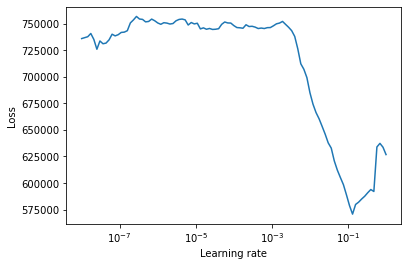

In [8]:
class FaceModel(pl.LightningModule):
    def __init__(self, lr = 1e-5):
        super().__init__()
        self.lr = lr
        self.example_input_array = torch.rand(1, 3, 64, 64)

        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.pool2 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 14 * 14, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        # print(x.shape)
        x = x.view(-1, 32 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch['face'], batch['targets']
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch['face'], batch['targets']
        y_hat = self(x)
        val_loss = F.mse_loss(y_hat, y)
        self.log('val_loss', val_loss)
        return val_loss

    def test_step(self, batch, batch_idx):
        x, y = batch['face'], batch['targets']
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('test_loss', loss)
        return loss


img_types = ['face']
d_train, d_val, d_test = create_datasets(*img_types, batch_size=128)

# train
logger = TensorBoardLogger(save_dir='logs', name='face', log_graph=True)
model = FaceModel()
trainer = pl.Trainer(logger=logger, gpus=1, max_epochs=20, benchmark=True, auto_lr_find=True)

# find optimal learning rate
lr_finder = trainer.tuner.lr_find(model, train_dataloader=d_train)
fig = lr_finder.plot(); fig.show()
suggested_lr = lr_finder.suggestion()
print("Suggested LR: {}".format(suggested_lr))

model = FaceModel(lr = suggested_lr)

trainer.fit(model, train_dataloader=d_train, val_dataloaders=d_val)

## Multiple input pytorch

In [23]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.face_c1 = nn.Conv2d(3, 16, 3)
        self.face_p1 = nn.MaxPool2d(2, 2)
        self.face_c2 = nn.Conv2d(16, 32, 3)
        self.face_p2 = nn.MaxPool2d(2, 2)

        self.l_eye_c1 = nn.Conv2d(3, 16, 3)
        self.l_eye_p1 = nn.MaxPool2d(2, 2)
        self.l_eye_c2 = nn.Conv2d(16, 32, 3)
        self.l_eye_p2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(12544, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, face, l_eye):
        face = self.face_p1(F.relu(self.face_c1(face)))
        face = self.face_p2(F.relu(self.face_c2(face)))
        face = face.view(-1, 32 * 14 * 14)

        l_eye = self.l_eye_p1(F.relu(self.l_eye_c1(l_eye)))
        l_eye = self.l_eye_p2(F.relu(self.l_eye_c2(l_eye)))
        l_eye = l_eye.view(-1, 32 * 14 * 14)

        out = torch.cat((face, l_eye), dim=1)

        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out


def train(d_train, d_val, d_test, device):
    net = Net()
    net.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=1e-5)

    writer = SummaryWriter('logs/multi/{}'.format(datetime.datetime.now().strftime("%m-%d-%Y %H-%M-%S")))
    writer.add_graph(net, [torch.rand(1, 3, 64, 64).to(device), torch.rand(1, 3, 64, 64).to(device)])

    for epoch in range(2):  # loop over the dataset multiple times
        running_loss = 0.0
        epoch_steps = 0
        for i, data in enumerate(d_train, 0):
            face, l_eye, labels = data['face'].to(device), data['l_eye'].to(device), data['targets'].to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(face, l_eye)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            epoch_steps += 1
            if i % 10 == 0:  # print every 2000 mini-batches
                print("[%d, %5d] loss: %.3f" % (epoch + 1, i + 1,
                                                running_loss / epoch_steps))
                running_loss = 0.0

            writer.add_scalar('Loss/train', loss.item(), i)

        # Validation loss
        val_loss = 0.0
        val_steps = 0
        for i, data in enumerate(d_val, 0):
            with torch.no_grad():
                face, l_eye, labels = data['face'].to(device), data['l_eye'].to(device), data['targets'].to(device)

                outputs = net(face, l_eye)
                loss = criterion(outputs, labels)
                val_loss += loss.cpu().numpy()
                val_steps += 1

        writer.add_scalar('Loss/test', val_loss, epoch)


# def test(net, d_test, device):
#     with torch.no_grad():
#         face, l_eye, labels = d_test['face'].to(device), d_test['l_eye'].to(device), d_test['targets'].to(device)

#         outputs = net(face, l_eye)

#         val_loss = 0
#         val_steps = 0
#         criterion = nn.MSELoss()
#         loss = criterion(outputs, labels)
#         val_loss += loss.cpu().numpy()
#         val_steps += 1

#     return val_loss / val_steps


def run():
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda:0"

    img_types = ['face', 'l_eye']
    d_train, d_val, d_test = create_datasets(*img_types, batch_size=128)

    train(d_train, d_val, d_test, device)

run()

[1,     1] loss: 789465.375
[1,    11] loss: 686345.602
[1,    21] loss: 367307.143
[1,    31] loss: 248397.151
[1,    41] loss: 188097.015
[1,    51] loss: 143288.632
[1,    61] loss: 121883.371
[1,    71] loss: 108115.594
[1,    81] loss: 91716.737
[1,    91] loss: 83862.948
[1,   101] loss: 74113.728
[2,     1] loss: 698187.125
[2,    11] loss: 696609.460
[2,    21] loss: 359886.777
[2,    31] loss: 243040.476
[2,    41] loss: 186095.562
[2,    51] loss: 148081.926
[2,    61] loss: 120961.307
[2,    71] loss: 106100.817
[2,    81] loss: 90558.151
[2,    91] loss: 85122.905
[2,   101] loss: 75817.007


## Multiple input lightning

In [26]:
class FaceModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.example_input_array = [torch.rand(1, 3, 64, 64)]*2

        self.face_c1 = nn.Conv2d(3, 16, 3)
        self.face_p1 = nn.MaxPool2d(2, 2)
        self.face_c2 = nn.Conv2d(16, 32, 3)
        self.face_p2 = nn.MaxPool2d(2, 2)

        self.l_eye_c1 = nn.Conv2d(3, 16, 3)
        self.l_eye_p1 = nn.MaxPool2d(2, 2)
        self.l_eye_c2 = nn.Conv2d(16, 32, 3)
        self.l_eye_p2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(12544, 32)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, face, l_eye):
        face = self.face_p1(F.relu(self.face_c1(face)))
        face = self.face_p2(F.relu(self.face_c2(face)))
        face = face.view(-1, 32 * 14 * 14)

        l_eye = self.l_eye_p1(F.relu(self.l_eye_c1(l_eye)))
        l_eye = self.l_eye_p2(F.relu(self.l_eye_c2(l_eye)))
        l_eye = l_eye.view(-1, 32 * 14 * 14)

        out = torch.cat((face, l_eye), dim=1)

        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-5)
        return optimizer

    def training_step(self, batch, batch_idx):
        face, l_eye = batch['face'], batch['l_eye']
        y_hat = self(face, l_eye)
        loss = F.mse_loss(y_hat, batch['targets'])
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        y_hat = self(batch['face'], batch['l_eye'])
        val_loss = F.mse_loss(y_hat, batch['targets'])
        self.log('val_loss', val_loss)
        return val_loss

    def test_step(self, batch, batch_idx):
        y_hat = self(batch['face'], batch['l_eye'])
        loss = F.mse_loss(y_hat, batch['targets'])
        self.log('test_loss', loss)
        return loss


img_types = ['face', 'l_eye']
d_train, d_val, d_test = create_datasets(*img_types, batch_size=128)

# train
logger = TensorBoardLogger(save_dir='logs', name='multi/{}'.format(datetime.datetime.now().strftime("%m-%d-%Y %H-%M-%S")), log_graph=True)
model = FaceModel()
trainer = pl.Trainer(logger=logger, gpus=1, max_epochs=5, benchmark=True)
trainer.fit(model, train_dataloader=d_train, val_dataloaders=d_val)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type      | Params | In sizes        | Out sizes      
---------------------------------------------------------------------------
0 | face_c1  | Conv2d    | 448    | [1, 3, 64, 64]  | [1, 16, 62, 62]
1 | face_p1  | MaxPool2d | 0      | [1, 16, 62, 62] | [1, 16, 31, 31]
2 | face_c2  | Conv2d    | 4.6 K  | [1, 16, 31, 31] | [1, 32, 29, 29]
3 | face_p2  | MaxPool2d | 0      | [1, 32, 29, 29] | [1, 32, 14, 14]
4 | l_eye_c1 | Conv2d    | 448    | [1, 3, 64, 64]  | [1, 16, 62, 62]
5 | l_eye_p1 | MaxPool2d | 0      | [1, 16, 62, 62] | [1, 16, 31, 31]
6 | l_eye_c2 | Conv2d    | 4.6 K  | [1, 16, 31, 31] | [1, 32, 29, 29]
7 | l_eye_p2 | MaxPool2d | 0      | [1, 32, 29, 29] | [1, 32, 14, 14]
8 | fc1      | Linear    | 401 K  | [1, 12544]      | [1, 32]        
9 | fc2      | Linear    | 66     | [1, 32]         | [1, 2]         
---------------------------------------

1

# Hyperparam optimization

## Single - lightning ray tune

In [36]:
class FaceModel(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.example_input_array = torch.rand(1, 3, 64, 64)
        self.layer_1_size = config["layer_1_size"]
        self.lr = config["lr"]

        self.conv1 = nn.Conv2d(3, 16, 3)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, 3)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(32 * 14 * 14, self.layer_1_size)
        self.fc2 = nn.Linear(self.layer_1_size, 2)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        # print(x.shape)
        x = x.view(-1, 32 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch['face'], batch['targets']  # needs to be fixed for multi input
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch['face'], batch['targets']
        y_hat = self(x)
        val_loss = F.mse_loss(y_hat, y)
        self.log('val_loss', val_loss)
        return val_loss

    def test_step(self, batch, batch_idx):
        x, y = batch['face'], batch['targets']
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        self.log('test_loss', loss)
        return loss


def train(config, num_epochs=2, num_gpus=1):
    img_types = ['face']
    d_train, d_val, d_test = create_datasets(*img_types, batch_size=config["batch"])

    model = FaceModel(config)
    trainer = pl.Trainer(
        max_epochs=num_epochs,
        gpus=num_gpus,
        logger=TensorBoardLogger(save_dir=tune.get_trial_dir(), name="", version=".", log_graph=True),
        progress_bar_refresh_rate=0,
        callbacks=[
            TuneReportCallback({"loss": "val_loss"}, on="validation_end")
        ])
    trainer.fit(model, train_dataloader=d_train, val_dataloaders=d_val)


def dir_name_string(trial):
    return str(trial.experiment_tag)


def tune_asha(num_samples=2, num_epochs=10, gpus_per_trial=1):
    config = {
        "batch": tune.choice([1 << i for i in range(2, 10)]),
        "lr": tune.loguniform(1e-5, 1e-1),
        "layer_1_size": tune.choice([16, 32, 64]),
    }

    scheduler = ASHAScheduler(
        max_t=num_epochs,
        grace_period=1,
        reduction_factor=2)

    reporter = JupyterNotebookReporter(
        overwrite=True,
        parameter_columns=list(config.keys()),
        metric_columns=["loss", "training_iteration"])

    analysis = tune.run(
        tune.with_parameters(
            train,
            num_epochs=num_epochs,
            num_gpus=gpus_per_trial),
        resources_per_trial={
            "cpu": 1,
            "gpu": gpus_per_trial
        },
        metric="loss",
        mode="min",
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter,
        name="face",
        trial_dirname_creator=dir_name_string,
        local_dir="F:/eyetracker/logs")

    print("Best hyperparameters found were: ", analysis.best_config)

tune_asha()

Trial name,status,loc,batch,lr,layer_1_size,loss,training_iteration
_inner_d8c9c_00000,TERMINATED,,1024,7.21522e-05,32,673987,10
_inner_d8c9c_00001,TERMINATED,,32,0.00377987,16,51721.9,10


2020-12-27 10:59:25,784	INFO tune.py:448 -- Total run time: 340.27 seconds (340.23 seconds for the tuning loop).
Best hyperparameters found were:  {'batch': 32, 'lr': 0.0037798680153013965, 'layer_1_size': 16}


## Multiple lightning ray tune

In [7]:
class FaceModel(pl.LightningModule):
    def __init__(self, config):
        super().__init__()
        self.example_input_array = [torch.rand(1, 3, 64, 64)]*2
        self.layer_1_size = config["layer_1_size"]
        self.lr = config["lr"]

        self.face_c1 = nn.Conv2d(3, 16, 3)
        self.face_p1 = nn.MaxPool2d(2, 2)
        self.face_c2 = nn.Conv2d(16, 32, 3)
        self.face_p2 = nn.MaxPool2d(2, 2)

        self.l_eye_c1 = nn.Conv2d(3, 16, 3)
        self.l_eye_p1 = nn.MaxPool2d(2, 2)
        self.l_eye_c2 = nn.Conv2d(16, 32, 3)
        self.l_eye_p2 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(32 * 14 * 14 * 2, self.layer_1_size)
        self.fc2 = nn.Linear(self.layer_1_size, 2)

    def forward(self, face, l_eye):
        face = self.face_p1(F.relu(self.face_c1(face)))
        face = self.face_p2(F.relu(self.face_c2(face)))
        face = face.view(-1, 32 * 14 * 14)

        l_eye = self.l_eye_p1(F.relu(self.l_eye_c1(l_eye)))
        l_eye = self.l_eye_p2(F.relu(self.l_eye_c2(l_eye)))
        l_eye = l_eye.view(-1, 32 * 14 * 14)

        out = torch.cat((face, l_eye), dim=1)

        out = F.relu(self.fc1(out))
        out = self.fc2(out)
        return out

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=self.lr)
        return optimizer

    def training_step(self, batch, batch_idx):
        y_hat = self(batch['face'], batch['l_eye'])
        loss = F.mse_loss(y_hat, batch['targets'])
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        y_hat = self(batch['face'], batch['l_eye'])
        val_loss = F.mse_loss(y_hat, batch['targets'])
        self.log('val_loss', val_loss)
        return val_loss

    def test_step(self, batch, batch_idx):
        y_hat = self(batch['face'], batch['l_eye'])
        loss = F.mse_loss(y_hat, batch['targets'])
        self.log('test_loss', loss)
        return loss


def train(config, num_epochs=2, num_gpus=1):
    img_types = ['face', 'l_eye']
    d_train, d_val, d_test = create_datasets(*img_types, batch_size=config["batch"])

    model = FaceModel(config)
    trainer = pl.Trainer(
        max_epochs=num_epochs,
        gpus=num_gpus,
        logger=TensorBoardLogger(save_dir=tune.get_trial_dir(), name="", version=".", log_graph=True),
        progress_bar_refresh_rate=0,
        callbacks=[
            TuneReportCallback({"loss": "val_loss"}, on="validation_end")
        ])
    trainer.fit(model, train_dataloader=d_train, val_dataloaders=d_val)


def dir_name_string(trial):
    return str(trial.experiment_tag)


def tune_asha(num_samples=20, num_epochs=20, gpus_per_trial=1):
    config = {
        "batch": tune.choice([1 << i for i in range(2, 9)]),
        "lr": tune.loguniform(1e-5, 1e-1),
        "layer_1_size": tune.choice([16, 32, 64]),
    }

    scheduler = ASHAScheduler(
        max_t=num_epochs,
        grace_period=1,
        reduction_factor=2)

    reporter = JupyterNotebookReporter(
        overwrite=True,
        parameter_columns=list(config.keys()),
        metric_columns=["loss", "training_iteration"])

    analysis = tune.run(
        tune.with_parameters(
            train,
            num_epochs=num_epochs,
            num_gpus=gpus_per_trial),
        resources_per_trial={
            "cpu": 1,
            "gpu": gpus_per_trial
        },
        metric="loss",
        mode="min",
        config=config,
        num_samples=num_samples,
        scheduler=scheduler,
        progress_reporter=reporter,
        name="multi",
        trial_dirname_creator=dir_name_string,
        local_dir="F:/eyetracker/logs")

    print("Best hyperparameters found were: ", analysis.best_config)

tune_asha()

Trial name,status,loc,batch,lr,layer_1_size,loss,training_iteration
_inner_54009_00000,TERMINATED,,128,0.00458689,16,12179.3,20
_inner_54009_00001,TERMINATED,,64,0.00175577,32,8404.33,20
_inner_54009_00002,TERMINATED,,4,3.59732e-05,64,141292,1
_inner_54009_00003,TERMINATED,,512,1.36201e-05,16,758800,1
_inner_54009_00004,TERMINATED,,4,0.0377513,32,14818.4,16
_inner_54009_00005,TERMINATED,,256,0.00708851,16,130869,1
_inner_54009_00006,TERMINATED,,256,0.0190519,32,140587,1
_inner_54009_00007,TERMINATED,,4,0.01377,64,3586.51,20
_inner_54009_00008,TERMINATED,,16,6.25249e-05,32,152617,1
_inner_54009_00009,TERMINATED,,8,0.000304739,32,30158.7,2


2020-12-27 20:06:35,782	INFO tune.py:448 -- Total run time: 5046.26 seconds (5046.22 seconds for the tuning loop).
Best hyperparameters found were:  {'batch': 4, 'lr': 0.013770023564889091, 'layer_1_size': 64}
